<a href="https://colab.research.google.com/github/Minsoo1036/DeepLearning-and-PyTorch/blob/main/Chapter3_AE_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder

In [4]:
# 1. Module Import

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [5]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113 Device: cuda


In [6]:
BATCH_SIZE = 32
EPOCHS = 10

In [7]:
# 3. FashionMNIST 데이터 다운로드
train_dataset = datasets.FashionMNIST(root="../data/FashionMNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root="../data/FashionMNIST",
                              train = False,
                              transform = transforms.ToTensor())


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/FashionMNIST/raw



In [8]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [9]:
#4. 데이터 확인하기 (1)
for (X_train,y_train) in train_loader:
    print('X_train:',X_train.size(),'type:',X_train.type())
    print('y_train:',y_train.size(),'type:',y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


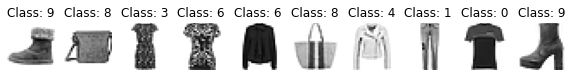

In [10]:
#5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize = (10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28),cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

In [20]:
#6. AutoEncoder(AE) 모델 설계하기

class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,28*28),
        )

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [21]:
# 7. Optimizer, Objective Function 설정하기

model = AE().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [22]:
#8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1,28*28).to(DEVICE)
        target = image.view(-1,28*28).to(DEVICE)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx*len(image), len(train_loader.dataset), 100.*batch_idx/len(train_loader),
                loss.item()
            ))

In [23]:
# 9. 학습되는 과정 중에 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_image = []
    gen_image = []
    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1,28*28).to(DEVICE)
            target = image.view(-1,28*28).to(DEVICE)
            encoded, decoded = model(image)

            test_loss += criterion(decoded, target).item()
            real_image.append(image.to("cpu"))
            gen_image.append(decoded.to("cpu"))

    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.207546
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.031951
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.025142
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.020290
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.018516
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.017512
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.018214
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.018226
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.018173
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.015125

[EPOCH: 1], 	Test Loss: 0.0005


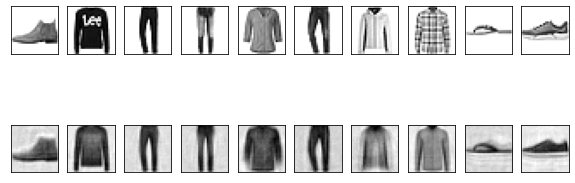

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.015814
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.015167
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.013396
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.011951
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.012421
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.014521
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.012064
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.011911
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.015647
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.012410

[EPOCH: 2], 	Test Loss: 0.0004


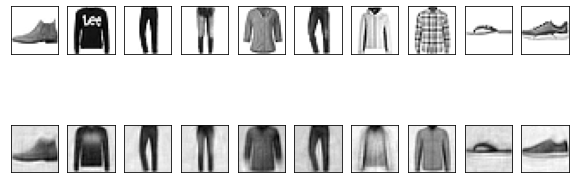

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.013181
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.014157
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.012622
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.011094
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.010888
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.009999
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.011217
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.011868
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.012246
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.009699

[EPOCH: 3], 	Test Loss: 0.0004


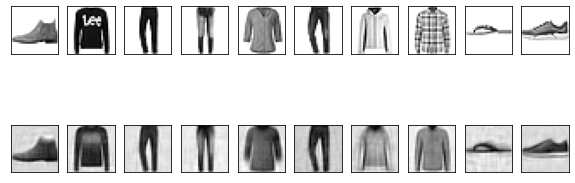

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.009876
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.015071
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.011397
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.010227
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.013071
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.011143
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.009903
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.011220
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.010862
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.009330

[EPOCH: 4], 	Test Loss: 0.0004


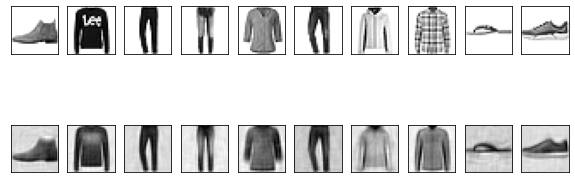

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.012737
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.009617
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.012350
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.013658
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.010350
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.011481
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.009452
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.010231
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.011002
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.008711

[EPOCH: 5], 	Test Loss: 0.0003


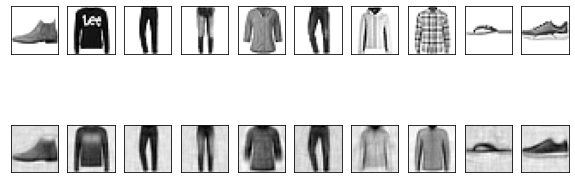

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.010684
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.010409
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.008499
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.010474
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.013143
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.009737
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.011803
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.011438
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.009045
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.010358

[EPOCH: 6], 	Test Loss: 0.0003


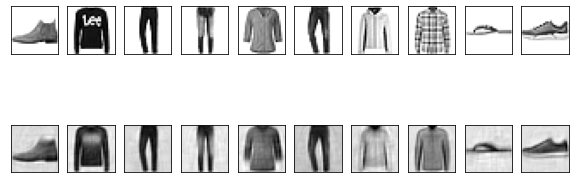

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.009987
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.010187
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.009064
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.010282
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.007960
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.012050
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.010018
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.013009
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.010297
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.009839

[EPOCH: 7], 	Test Loss: 0.0003


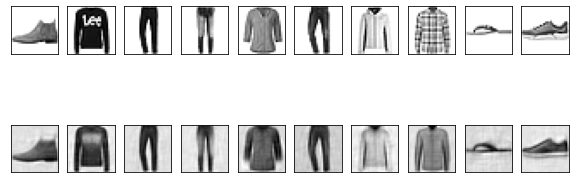

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.011390
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.008489
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.009990
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.009244
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.013212
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.009721
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.009962
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.010557
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.010328
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.010518

[EPOCH: 8], 	Test Loss: 0.0003


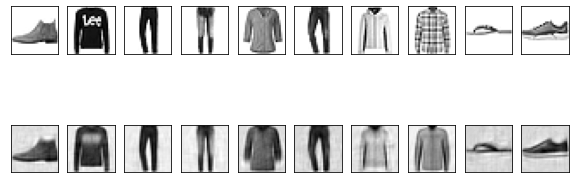

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.008510
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.008276
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.012209
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.010565
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.009249
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.010601
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.008410
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.008853
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.010369
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.010128

[EPOCH: 9], 	Test Loss: 0.0003


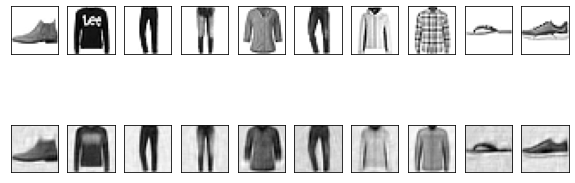

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.009612
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.009805
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.009396
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.009742
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.008418
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.010699
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.010887
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.009210
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.008904
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.008837

[EPOCH: 10], 	Test Loss: 0.0003


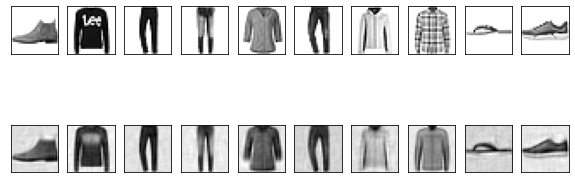

In [24]:
# 10. AutoEncoder 학습을 실행하며 Test set의 Reconstruction Error 확인하기

for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))
    f, a = plt.subplots(2,10,figsize=(10,4)) #세로길이 2, 가로길이 10
    
    for i in range(10):
        img = np.reshape(real_image[0][i], (28,28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(gen_image[0][i], (28,28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
        
    plt.show()
